# This is the demo of TAC-GAN on MOG (mixture of gaussian) 

Load the needed package

# Import and libraries

In [1]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from mmd_metric import polynomial_mmd
from torch import autograd
from torch.nn import utils
from torch.nn import init
from tqdm import tqdm
import pdb

# Classes for cGAN

In [208]:
#######G network

class G_gaussian(nn.Module):

    def __init__(self, nz,num_classes=2):
        super(G_gaussian, self).__init__()

        self.embed = nn.Embedding(num_embeddings=num_classes, embedding_dim=nz)

        self.decode = nn.Sequential(

            nn.Linear(nz*2,10),
            nn.Tanh(),
            nn.Linear(10, 10),
            #nn.Tanh(),
            nn.Linear(10, 1),
            #nn.Tanh(),
            #nn.Linear(10, 1),
        )


        self.__initialize_weights()

    def forward(self, z, label, output=None):

        input = torch.cat([z,self.embed(label)],dim=1)
        x = input.view(input.size(0), -1)
        output = self.decode(x)

        return output

    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)
                

#####D network
class D_gaussian(nn.Module):

    def __init__(self, num_classes=10, AC=True, MINE=False):
        super(D_gaussian, self).__init__()
        
        self.AC = AC
        self.MINE = MINE
        
        # spectral norm
        #self.encode = nn.Sequential(utils.spectral_norm(nn.Linear(1, 10)), nn.Tanh(), utils.spectral_norm(nn.Linear(10, 10)), nn.Tanh(), utils.spectral_norm(nn.Linear(10, 10)), nn.Tanh())
        #self.gan_linear = utils.spectral_norm(nn.Linear(10, 1))
        #self.aux_linear = utils.spectral_norm(nn.Linear(10, num_classes))
        #self.tac_linear = utils.spectral_norm(nn.Linear(10, num_classes))
        #self.mine_linear = utils.spectral_norm(nn.Linear(10, 1))
        
        self.encode = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10))
        #self.encode = nn.Sequential(nn.Linear(1, 10))
        #self.encode = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh())
        self.gan_linear = nn.Linear(10, 1)
        self.aux_linear = nn.Linear(10, num_classes)
        self.tac_linear = nn.Linear(10, num_classes)
        self.mine_linear = nn.Linear(10, 1)
        
        self.ma_et = None

        if not self.AC or self.MINE:
            #self.projection = utils.spectral_norm(nn.Embedding(num_embeddings=num_classes, embedding_dim=10))
            self.projection = nn.Embedding(num_embeddings=num_classes, embedding_dim=10)

        self.sigmoid = nn.Sigmoid()
        self.__initialize_weights()

    def forward(self, input, y=None):

        x = self.encode(input)
        x = x.view(-1, 10)
        
        if y is None:
            c1 = self.aux_linear(x)
            c2 = self.tac_linear(x)
            s = self.gan_linear(x)
            if not self.AC:
                s += (self.projection(y)*x).sum(dim=1, keepdim=True)
            s = self.sigmoid(s)
            return s.squeeze(1), c1.squeeze(1), c2.squeeze(1)
        else:
            s = self.mine_linear(x)
            if self.AC and self.MINE:
                s += (self.projection(y) * x).sum(dim=1, keepdim=True)
            return s.squeeze(1)

    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)


#####D network
class T_gaussian(nn.Module):

    def __init__(self, num_classes=3, use_projection=False):
        super(T_gaussian, self).__init__()
        self.use_projection = use_projection
        self.num_classes = num_classes
        
        # spectral norm
        #self.encode = nn.Sequential(utils.spectral_norm(nn.Linear(1, 10)), nn.Tanh(), utils.spectral_norm(nn.Linear(10, 10)), nn.Tanh(), utils.spectral_norm(nn.Linear(10, 10)), nn.Tanh())
        #self.mine_linear = utils.spectral_norm(nn.Linear(10, 1))
        
        if use_projection:
            self.encode = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10))
            #self.projection = utils.spectral_norm(nn.Embedding(num_embeddings=num_classes, embedding_dim=10))
            self.projection = nn.Embedding(num_embeddings=num_classes, embedding_dim=10)
        else:
            #self.encode = nn.Sequential(nn.Linear(num_classes+1, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh())
            self.encode = nn.Sequential(nn.Linear(num_classes+1, 10), nn.Tanh(), nn.Linear(10, 10), nn.Tanh(), nn.Linear(10, 10))
        self.mine_linear = nn.Linear(10, 1)
        self.ma_et = None

        self.__initialize_weights()

    def forward(self, input, y):
        if not self.use_projection:
            y_onehot = torch.zeros(y.size(0), self.num_classes).cuda().scatter_(1, y.view(y.size(0), 1), 1)
            input = torch.cat((y_onehot, input), dim=1)
        x = self.encode(input)
        x = x.view(-1, 10)
        s = self.mine_linear(x)
        if self.use_projection:
            s += (self.projection(y) * x).sum(dim=1, keepdim=True)
        return s

    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)

# class T_gaussian(nn.Module):

#     def __init__(self, num_classes=3):
#         super(T_gaussian, self).__init__()
#         self.num_classes = num_classes
        
#         # spectral norm
#         #self.encode = nn.Sequential(utils.spectral_norm(nn.Linear(1, 10)), nn.Tanh(), utils.spectral_norm(nn.Linear(10, 10)), nn.Tanh(), utils.spectral_norm(nn.Linear(10, 10)), nn.Tanh())
#         #self.mine_linear = utils.spectral_norm(nn.Linear(10, 1))
        
#         self.encode_phi = nn.Sequential(nn.Linear(1, 10), nn.Tanh())
#         self.projection = nn.Embedding(num_embeddings=num_classes, embedding_dim=10)
#         self.encode_psi = nn.Sequential(nn.Linear(20, 10), nn.Tanh(), nn.Linear(10, 10))
        
#         self.mine_linear = nn.Linear(10, 1)
#         self.ma_et = None
#         self.__initialize_weights()

#     def forward(self, input, y):
        
#         x = self.encode_phi(input)
#         x = x.view(-1, 10)
#         x = torch.cat((x, self.projection(y)), dim=1)
#         x = self.encode_psi(x)
#         s = self.mine_linear(x)
#         return s

#     def __initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 m.weight.data.normal_(0.0, 0.02)
#             elif isinstance(m, nn.Linear):
#                 m.weight.data.normal_(0.0, 0.02)
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.normal_(1.0, 0.02)
#                 m.bias.data.fill_(0)

# Helper functions to plot the results

In [3]:
def plot_density(flights,binwidth=0.1):
    ax = plt.subplot(1,1,1)

    # Draw the plot
    ax.hist(flights, bins=int(180 / binwidth),
            color='blue', edgecolor='black')

    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size=30)
    ax.set_xlabel('Delay (min)', size=22)
    ax.set_ylabel('Flights', size=22)

    plt.tight_layout()
    plt.show()

# Runner

In [350]:
####TAC-GAN: set AC=True, MI=True, AC-GAN:set AC=True, MI=False, Projection-GAN: set AC=False, MI=False
def train(data1, data2, data3, nz, G, D, T, optd, optg, optt, bs, AC=True, TAC=True, MINE=False, lambda_m=1.0, lambda_g=1.0, ada=True):
    full_data = torch.cat([data1, data2, data3], dim=0).unsqueeze(dim=1)
    full_label = torch.cat([torch.ones(data1.size(0)).cuda().long()*0, torch.ones(data2.size(0)).cuda().long()*1, torch.ones(data3.size(0)).cuda().long()*2], dim=0)
    N = full_data.size(0)
    
    # shuffle
    idx = torch.randperm(N)
    full_data = full_data[idx, ...]
    full_label = full_label[idx, ...]
    
    for epoch in range(20):
        for i in range(int(np.ceil(N / bs))):
            data = full_data[bs * i:bs * i + bs, ...]
            label = full_label[bs * i:bs * i + bs, ...]
            fake_label = torch.LongTensor(bs).random_(0, 3).cuda()
            #fake_label = label
            z = torch.randn(bs, nz).cuda()
            
            ###D
            # train with real
            if AC:
                d_real, c1_real, _ = D(data)
            else:
                # Proj-cGAN
                d_real, _, _ = D(data, label)
            D_loss = F.binary_cross_entropy(d_real, torch.ones(bs).cuda())
            if AC:
                D_loss += F.cross_entropy(c1_real, label)
            
            # train with fake
            fake_data = G(z, label=fake_label)
            if AC:
                d_fake, c1_fake, c2_fake = D(fake_data.detach())
            else:
                # Proj-cGAN
                d_fake, _, _ = D(fake_data.detach(), fake_label)
            D_loss += F.binary_cross_entropy(d_fake, torch.zeros(bs).cuda())
            #if AC:
            #    D_loss += F.cross_entropy(c1_fake, fake_label)
            if TAC:
                D_loss += F.cross_entropy(c2_fake, fake_label)
            
            optd.zero_grad()
            D_loss.backward()
            optd.step()

            ###T
            if MINE:
                for _ in range(1):
                    #fake_label_bar = fake_label[torch.randperm(bs), ...]
                    fake_label_bar = torch.LongTensor(bs).random_(0, 3).cuda()
                    et = torch.mean(torch.exp(T(fake_data.detach(), fake_label_bar)))
                    if T.ma_et is None:
                        T.ma_et = et.detach().item()
                    T.ma_et += 0.002 * (et.detach().item() - T.ma_et)
                    mi = torch.mean(T(fake_data.detach(), fake_label)) - torch.log(et) * et.detach() / T.ma_et
                    T_loss = -mi
                    optt.zero_grad()
                    T_loss.backward()
                    optt.step()

            #####G step
            if i % 2 == 0:
                z = torch.randn(bs, nz).cuda()
                fake_label = torch.LongTensor(bs).random_(0, 3).cuda()
                fake_data = G(z, label=fake_label)
                fake_label_bar = fake_label[torch.randperm(bs), ...]
                if AC:
                    d_fake, c1_fake, c2_fake = D(fake_data)
                else:
                    # Proj-cGAN
                    d_fake, _, _ = D(fake_data, fake_label)

                G_loss = F.binary_cross_entropy(d_fake, torch.ones(bs).cuda())

                if AC:
                    G_loss += F.cross_entropy(c1_fake, fake_label)
                if TAC:
                    G_loss -= F.cross_entropy(c2_fake, fake_label)

                optg.zero_grad()
                
                #MINE
                if MINE:
                    mi = torch.mean(T(fake_data, fake_label)) - torch.log(torch.mean(torch.exp(T(fake_data, fake_label_bar))))
                    if ada:
                        grad_u = autograd.grad(G_loss, G.parameters(), create_graph=True, retain_graph=True, only_inputs=True)
                        grad_m = autograd.grad(lambda_m * mi, G.parameters(), create_graph=True, retain_graph=True, only_inputs=True)
                        grad_u_flattened = torch.cat([g.view(-1) for g in grad_u])
                        grad_m_flattened = torch.cat([g.view(-1) for g in grad_m])
                        grad_u_norm = grad_u_flattened.pow(2).sum().sqrt()
                        grad_m_norm = grad_m_flattened.pow(2).sum().sqrt()
                        grad_a_ratio = torch.min(grad_u_norm, grad_m_norm) / grad_m_norm * lambda_m * lambda_g
                        for p, g_u, g_m in zip(G.parameters(), grad_u, grad_m):
                            p.grad = g_u + g_m * grad_a_ratio
                    else:
                        G_loss += lambda_m * mi
                        G_loss.backward()
                else:
                    G_loss.backward()
                optg.step()
        if epoch % 2 == 0:
            print(f'epoch {epoch} done.')

# Visualize and evaluation

Running the 1-D MOG toy experiments of different distance between different gaussian components. Cost about 10 min in 1080ti

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


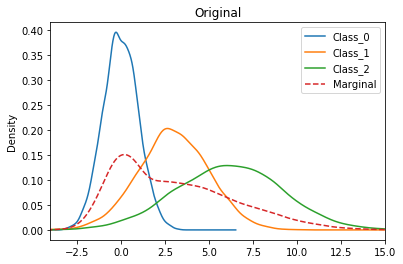

In [171]:

######create folder to save the result
distance = 3
if os.path.exists(os.path.join('MOG','1D', str(distance) + '_1D')):
    pass
else:
    os.makedirs(os.path.join('MOG','1D', str(distance) + '_1D'))
save_path = os.path.join('MOG','1D', str(distance) + '_1D')

######Generate MOG data of different mean and variance
data1 = torch.randn(6400).cuda()
data2 = torch.randn(6400).cuda() * 2 + distance
data3 = torch.randn(6400).cuda() * 3 + distance * 2
# data1 = torch.randn(640).cuda() * 0.5
# data2 = torch.randn(640).cuda() * 0.5 + distance
# data3 = torch.randn(640).cuda() * 0.5 + distance * 2

df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1['score_{0}'.format(0)] = data1.cpu().numpy()
df1['score_{0}'.format(1)] = data2.cpu().numpy()
df1['score_{0}'.format(2)] = data3.cpu().numpy()
r_data = torch.cat([data1, data2, data3], dim=0).cpu().numpy()
df2['score_{0}'.format(2)] = r_data
np.save(save_path+'/o_data',r_data)

######Plot the distribution of original data
fig, ax = plt.subplots(1, 1)
for s in df1.columns:
    df1[s].plot(kind='kde')

for s in df2.columns:
    df2[s].plot(style='--',kind='kde')
plt.xlim((-4, 9 + distance * 2))
ax.legend(["Class_0", "Class_1","Class_2","Marginal"])
plt.title('Original')
fig.savefig(save_path + '/original.eps')

# Build Network

In [200]:
####TAC-GAN: set AC=True, MI=True, AC-GAN:set AC=True, MI=False, Projection-GAN: set AC=False, MI=False
##Default TAC-GAN
AC = True
TAC = False
MINE = True
no_share = True
if AC:
    if TAC:
        name = 'TAC'
    elif MINE:
        name = 'MINE'
    else:
        name = 'AC'
else:
    name = 'Projection'

#####Bulding network
nz = 1
G = G_gaussian(nz=nz, num_classes=3).cuda()
D = D_gaussian(num_classes=3, AC=AC, MINE=(MINE and not no_share)).cuda()
if no_share:
    T = T_gaussian(num_classes=3).cuda()
else:
    T = D

optg = optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
optd = optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))
if no_share:
    optt = optim.Adam(T.parameters(), lr=0.002, betas=(0.5, 0.999))
else:
    optt = optd

MINE
epoch 0 done.
epoch 2 done.
epoch 4 done.
epoch 6 done.
epoch 8 done.
epoch 10 done.
epoch 12 done.
epoch 14 done.
epoch 16 done.
epoch 18 done.
Training finished


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


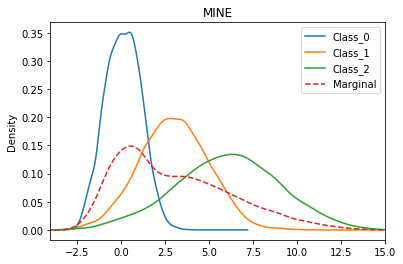

In [367]:
#####Train network
# ada = True
# lambda_m = 1.04
# lambda_g = 1.02 # 1./lambda_m
# lambda_m = 1.1
# lambda_g = 0.97 # 1./lambda_m

ada = False
lambda_m = 1.0
lambda_g = 1.0 # 1./lambda_m

print(name)
train(data1, data2, data3, nz, G, D, T, optd, optg, optt, 128, AC=AC, TAC=TAC, MINE=MINE, lambda_m=lambda_m, lambda_g=lambda_g, ada=ada)
print('Training finished')

#####Sample data from Generator
z = torch.randn(6400, nz).cuda()
label = torch.zeros(6400).long().cuda()  # torch.LongTensor(10000).random_(2).cuda()#
data1_g = G(z=z, label=label).squeeze().cpu().detach()

z = torch.randn(6400, nz).cuda()
label = torch.ones(6400).long().cuda()  # torch.LongTensor(10000).random_(2).cuda()#
data2_g = G(z=z, label=label).squeeze().cpu().detach()

z = torch.randn(6400, nz).cuda()
label = torch.ones(6400).long().cuda() + 1  # torch.LongTensor(10000).random_(2).cuda()#
data3_g = G(z=z, label=label).squeeze().cpu().detach()

df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1['score_{0}'.format(0)] = data1_g.numpy()
df1['score_{0}'.format(1)] = data2_g.numpy()
df1['score_{0}'.format(2)] = data3_g.numpy()
g_data = torch.cat([data1_g, data2_g, data3_g], dim=0).numpy()
df2['score_{0}'.format(2)] = g_data

#####Plot generated conditional distribution
fig, ax = plt.subplots(1, 1)
for s in df1.columns:
    df1[s].plot(kind='kde')

for s in df2.columns:
    df2[s].plot(style='--',kind='kde')

plt.xlim((-4, 9 + distance * 2))
ax.legend(["Class_0", "Class_1", "Class_2", "Marginal"])
plt.title(name)
fig.savefig(save_path + '/'+name+'.eps')

# Evaluate the MMD distance between true data and generated data

In [368]:
mean0_0, var0_0 = polynomial_mmd(np.expand_dims(data1_g.numpy(), axis=1), np.expand_dims(data1.cpu().numpy(), axis=1))
mean0_1, var0_1 = polynomial_mmd(np.expand_dims(data2_g.numpy(), axis=1), np.expand_dims(data2.cpu().numpy(), axis=1))
mean0_2, var0_2 = polynomial_mmd(np.expand_dims(data3_g.numpy(), axis=1), np.expand_dims(data3.cpu().numpy(), axis=1))
mean0, var0 = polynomial_mmd(np.expand_dims(g_data, axis=1), np.expand_dims(r_data, axis=1))
print('the distance of class 0 is : ', mean0_0)
print('the distance of class 1 is : ', mean0_1)
print('the distance of class 2 is : ', mean0_2)
print('the distance of marginal is : ', mean0)

the distance of class 0 is :  0.05523531508350832
the distance of class 1 is :  -0.02827075257926026
the distance of class 2 is :  0.28505027065875765
the distance of marginal is :  -0.14943767093518545
